# Introduction to Image Processing

Guillaume Lemaitre - Fabrice Meriaudeau

## Lecture 2 - Intensity Transformation

The needed libraries are imported in the cell below

In [14]:
%matplotlib inline
%pprint off

# Import the library to show images, plot, etc.
import matplotlib.pyplot as plt
# Import functionality for the color map
import matplotlib.cm as cm

# Other plotting library
#import seaborn as sns
#sns.set()

# Import the library to manage matrix and array
import numpy as np

# Import the library of linear algebra
import scipy as sp

# Import the image processing toolbox
### Module to read, write, etc.
from skimage import io
### Module for color conversion
from skimage import color
### Function to convert the image on 8 bits
from skimage import img_as_ubyte
### Module to transform images
from skimage import exposure
### Module to apply the filter
from skimage import filters
from skimage.filters import rank

Pretty printing has been turned OFF


### Original image

In [ ]:
# Define the image to read
filename = 'images/angle_0.bmp'

# Open an image
img = io.imread(filename)
# Convert the image into grayscale
img = color.rgb2gray(img)
# Convert the image into 8 bits
img = img_as_ubyte(img)

max_img = 255

# Show the image with grey colormap
plt.figure()
plt.imshow(img, cmap = cm.Greys_r)
plt.show()

# Plot the histogram of this figure
plt.figure()
n, bins, patches = plt.hist(img, max_img, 
                            normed=True, range=(0, max_img),
                            histtype='stepfilled')
plt.show()

## Intensity transformations

### Negative transform

Define the function to perform the negative transform

In [ ]:
def neg_trans(x, max_int):
    return img_as_ubyte(max_int - x)

Let's study this transformation for all possible intenities

In [ ]:
# Define a set of 256 values ranging from 0 to 255
x = np.arange(max_img, dtype='uint8')

# Plot the transform function
plt.figure()
plt.plot(x, neg_trans(x, max_img))
plt.xlabel('Input intensities')
plt.ylabel('Output intensities')
plt.title('Negative transform')
plt.show()

Apply to a real image

In [ ]:
# Compute the negative image
### Assuming an 8 bits coded image
neg_img = neg_trans(img, max_img)

# Show the image with grey colormap
plt.figure()
plt.imshow(neg_img, cmap = cm.Greys_r)
plt.show()

# Plot the histogram of this figure
plt.figure()
n, bins, patches = plt.hist(neg_img, max_img, 
                            normed=True, range=(0, max_img),
                            histtype='stepfilled')
plt.show()

### Log transform

Define the function to perform the negative transform

In [ ]:
def log_trans(x, c, min_int, max_int):
    # Rescale the input between 0 and 1
    scale = float(max_int - min_int)
    # Compute the transformation
    return np.round(c * scale * np.log2(1.0 +  x / scale)).astype('uint8')

Let's study this transformation for all possible intenities

In [ ]:
# Define a set of 256 values ranging from 0 to 255
x = np.arange(max_img, dtype='uint8')

# Define the parameter c
c = np.linspace(.1, 1.2, num=10)

# Plot the transform function
plt.figure()
for c_par in c:
    plt.plot(x, log_trans(x, c_par, 0, max_img))
plt.xlabel('Input intensities')
plt.ylabel('Output intensities')
plt.title('Log transform')
plt.show()

Apply to a real image

In [ ]:
# Compute the negative image
c = 5.
log_img = log_trans(img, c_par, 0, max_img)

# Show the image with grey colormap
plt.figure()
plt.imshow(log_img, cmap = cm.Greys_r)
plt.show()

# Plot the histogram of this figure
plt.figure()
n, bins, patches = plt.hist(log_img, max_img, 
                            normed=True, range=(0, max_img),
                            histtype='stepfilled')
plt.show()

### Power-law (Gamma) transform

Define the function to perform the negative transform

In [ ]:
def gamma_trans(x, gamma, min_int, max_int):
    # Rescale the input between 0 and 1
    scale = float(max_int - min_int)
    # Compute the transformation
    return ((x / scale) ** gamma) * scale * c

Let's study this transformation for all possible intenities

In [ ]:
# Define a set of 256 values ranging from 0 to 255
x = np.arange(max_img, dtype='uint8')

# Define the parameter c
gamma = np.logspace(-1, 1., num=20)

# Plot the transform function
plt.figure()
for g in gamma:
    plt.plot(x, gamma_trans(x, g, 0, max_img))
plt.xlabel('Input intensities')
plt.ylabel('Output intensities')
plt.title('Gamma transform')
plt.show()

Apply to real image

In [ ]:
# Compute the negative image
gamma = 0.40
gamma_img = gamma_trans(img, gamma, 0, max_img)

# Show the image with grey colormap
plt.figure()
plt.imshow(gamma_img, cmap = cm.Greys_r)
plt.show()

# Plot the histogram of this figure
plt.figure()
n, bins, patches = plt.hist(gamma_img, max_img, 
                            normed=True, range=(0, max_img),
                            histtype='stepfilled')
plt.show()

### Contrast stretching

In [ ]:
def con_str(x):
    ### Find the maximum
    max_int = np.max(x)
    ### Find the minimum
    min_int = np.min(x)
    
    return np.round((x - min_int) * ((255. - 0.) / (max_int - min_int)) + 0.).astype('uint8')

Try on real image

In [ ]:
# Print the extremum
print 'The minimum and maximum of the image were: {} - {}'.format(np.min(img), np.max(img))

# Compute the stretch image
str_img = con_str(img)

print 'The minimum and maximum of the image were: {} - {}'.format(np.min(str_img), np.max(str_img))

# Show the image with grey colormap
plt.figure()
plt.imshow(str_img, cmap = cm.Greys_r)
plt.show()

# Plot the histogram of this figure
plt.figure()
n, bins, patches = plt.hist(str_img, max_img, 
                            normed=True, range=(0, max_img),
                            histtype='stepfilled')
plt.show()

### Intensity-level slicing

In [ ]:
def rescale_piece(x, x_norm, org_inf, org_sup, pro_inf, pro_sup):
    # Find the index of the data which have to be normalised in this round
    idx = np.nonzero(np.bitwise_and(x >= org_inf, x < org_sup))
    # Apply the linear rescaling
    x_norm[idx] = pro_inf + np.multiply((x[idx] - org_inf), np.divide(pro_sup - pro_inf, org_sup - org_inf))
    
    return x_norm
    
def piece_norm(x, curr_land, proj_land):
    x_norm = x.copy()
    # We need to go through the n_landmarks - 1 parts
    for ld in range(len(curr_land) - 1):
        x_norm = rescale_piece(x, x_norm, 
                               curr_land[ld], curr_land[ld+1],
                               proj_land[ld], proj_land[ld+1])
    return np.round(x_norm).astype('uint8')

On a real image

In [ ]:
### Define the mapping
curr = [0., 10., 50., 230., 255.]
proj = [0., 50., 70., 100., 255.]

piece_norm_img = piece_norm(img, curr, proj)

# Show the image with grey colormap
plt.figure()
plt.imshow(piece_norm_img, cmap = cm.Greys_r)
plt.show()

# Plot the histogram of this figure
plt.figure()
n, bins, patches = plt.hist(piece_norm_img, max_img, 
                            normed=True, range=(0, max_img),
                            histtype='stepfilled')
plt.show()

### Bit-plane slicing

In [ ]:
def bit_plane_slicing(x, plane):
    # Remember the shape of x
    x_shape = x.shape
    # vectorise x
    x_vec = x.reshape(-1)
    
    x_conv = []
    for i in x_vec:
        # Compute the binary code of i
        i_bin = list(format(i, '#b10'))
        # Put to zero the right place
        i_bin[-plane] = str(0)
        x_conv.append(int(''.join(i_bin), 2))
        
    # Reshape the vector to whatever it was
    return np.reshape(x_conv, x_shape)        

In [ ]:
bit_img = bit_plane_slicing(img, 7)

# Show the image with grey colormap
plt.figure()
plt.imshow(bit_img, cmap = cm.Greys_r)
plt.show()

# Plot the histogram of this figure
plt.figure()
n, bins, patches = plt.hist(bit_img, max_img, 
                            normed=True, range=(0, max_img),
                            histtype='stepfilled')
plt.show()

### Histogram Equalization

Define the a function to find the mapping via the cdf

In [2]:
def find_mapping(x, min_int, max_int):
    # Compute the pdf of the image
    pdf, bin_edges = np.histogram(x, bins=max_int+1, range=(min_int, max_int), density=True)
    pdf = pdf / np.sum(pdf)
    
    return find_function(pdf, min_int, max_int)

In [3]:
def find_function(pdf, min_int, max_int):
    # Compute the cdf
    cdf = np.cumsum(pdf)
    
    # Multiply the cdf by the number of gray values
    cdf_real = cdf * float(max_int)
    # Round the cdf
    cdf_int = np.floor(cdf_real).astype('int')
    
    return cdf_int

In [4]:
def make_mapping(i, mapping):
    return mapping[i]

Map an image using parallel processing

In [5]:
def map_image(img, mapping):
    import multiprocessing
    from joblib import Parallel, delayed
    
    num_cores = multiprocessing.cpu_count()
    img_flat = Parallel(n_jobs=num_cores)(delayed(make_mapping)(px, mapping) for px in img.reshape(-1))
    
    return np.reshape(img_flat, img.shape)

Define histogram equalisation

In [6]:
def hist_eq(img, min_int, max_int):
    mapping = find_mapping(img, min_int, max_int)
    return map_image(img, mapping)

Apply histogram equalization on low contrast image

/home/lemaitre/anaconda/lib/python2.7/site-packages/skimage/util/dtype.py:111: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))


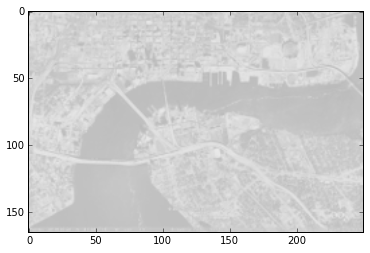

/home/lemaitre/anaconda/lib/python2.7/site-packages/matplotlib/axes/_axes.py:5616: UserWarning: 2D hist input should be nsamples x nvariables;
 this looks transposed (shape is 165 x 250)
  'this looks transposed (shape is %d x %d)' % x.shape[::-1])


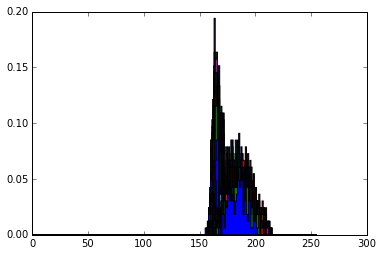

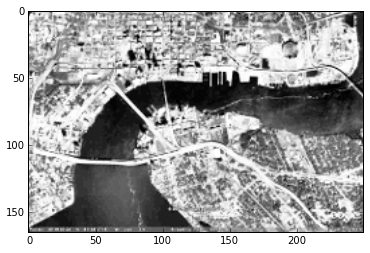

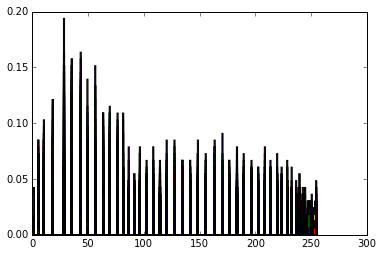

In [7]:
# Define the image to read
filename = 'images/low_contrast.png'

# Open an image
img = io.imread(filename)
# Convert the image into grayscale
img = color.rgb2gray(img)
# Convert the image into 8 bits
img = img_as_ubyte(img)

max_img = 255

# Show the image with grey colormap
plt.figure()
plt.imshow(img, cmap = cm.Greys_r, vmin=0,vmax=255)
plt.show()

# Plot the histogram of this figure
plt.figure()
n, bins, patches = plt.hist(img, max_img, 
                            normed=True, range=(0, max_img),
                            histtype='stepfilled')
plt.show()

# Compute the equalised image
img_eq = hist_eq(img, 0, max_img)

# Show the image with grey colormap
plt.figure()
plt.imshow(img_eq, cmap = cm.Greys_r, vmin=0,vmax=255)
plt.show()

# Plot the histogram of this figure
plt.figure()
n, bins, patches = plt.hist(img_eq, max_img, 
                            normed=True, range=(0, max_img),
                            histtype='stepfilled')
plt.show()

### Histogram matching

Define a function to compute the inverse mapping

In [8]:
def find_inverse_mapping(mapping):
    # Initialise the inverse
    inv_mapping = np.zeros(mapping.shape)
    # Find the index that we can affect for sure
    idx_inv_map = np.unique(mapping)
    
    # For each index
    for idx in idx_inv_map:
        # Find the corresponding index value
        int_val = np.where(mapping == idx)[0][0]
        # Affect this value for the inverse mapping
        inv_mapping[idx] = int_val
        
    # Find the first index which is not zero
    first_elt_idx = np.nonzero(inv_mapping)[0][0]
    for i, elt in enumerate(inv_mapping[first_elt_idx:-1]):
        if (elt == 0):
            inv_mapping[i + first_elt_idx] = inv_mapping[i + first_elt_idx - 1]
        
    return inv_mapping.astype('uint8')

Define histogram matching function

In [9]:
def hist_match(img, pdf_to_match, min_int, max_int):
    # Equalize img
    img_eq = hist_eq(img, min_int, max_int)
    
    # We need to make the matching now
    ### Compute the transform G
    G = find_function(pdf_to_match, min_int, max_int)
    ### But we need the inverse
    G_1 = find_inverse_mapping(G)
    
    return map_image(img_eq, G_1)    

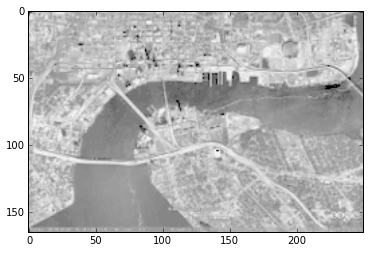

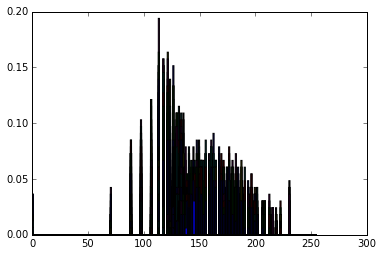

In [10]:
# Create a manual pdf following a gaussian distribution
from scipy.stats import norm

x = np.arange(max_img+1)
pdf_to_fit = norm.pdf(x, 150, 30)

img_match = hist_match(img, pdf_to_fit, 0, max_img)

# Show the image with grey colormap
plt.figure()
plt.imshow(img_match, cmap = cm.Greys_r, vmin=0,vmax=255)
plt.show()

# Plot the histogram of this figure
plt.figure()
n, bins, patches = plt.hist(img_match, max_img, 
                            normed=True, range=(0, max_img),
                            histtype='stepfilled')
plt.show()

## Spatial Filtering

### Smoothing

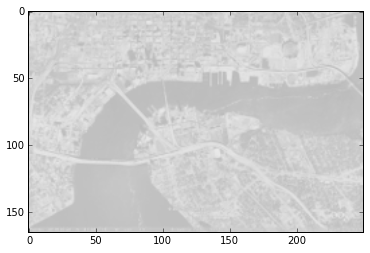

In [16]:
# Define the image to read
filename = 'images/low_contrast.png'

# Open an image
img = io.imread(filename)
# Convert the image into grayscale
img = color.rgb2gray(img)
# Convert the image into 8 bits
img = img_as_ubyte(img)

max_img = 255

# Show the image with grey colormap
plt.figure()
plt.imshow(img, cmap = cm.Greys_r, vmin=0,vmax=255)
plt.show()

Apply mean filtering

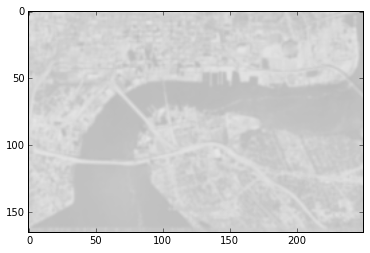

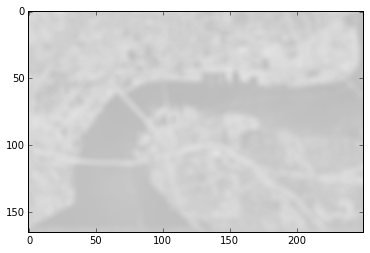

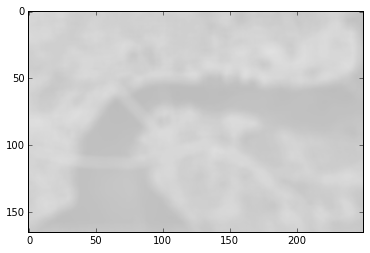

In [22]:
# Import the morpho math element to apply the filter
from skimage.morphology import disk

sz_disk = [1, 3, 5]

for f in sz_disk:
    avg = rank.mean(img, disk(f))
    # Show the image with grey colormap
    plt.figure()
    plt.imshow(avg, cmap = cm.Greys_r, vmin=0,vmax=255)
    plt.show()

Apply median filtering

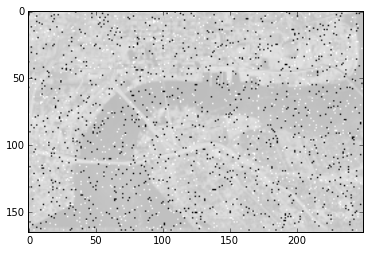

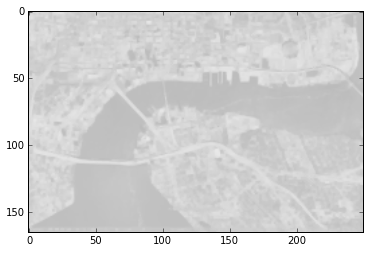

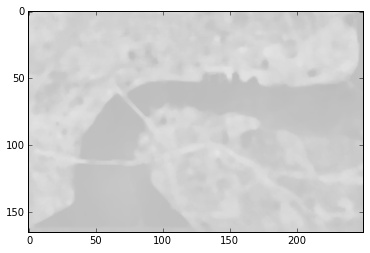

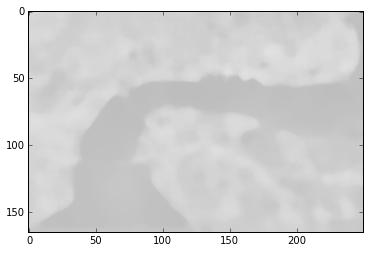

In [23]:
# import the function to add some noise
from skimage.util import random_noise

img_noise = random_noise(img, mode='s&p')
plt.figure()
plt.imshow(img_noise, cmap = cm.Greys_r, vmin=0.,vmax=1.)
plt.show()

# Apply median filtering
sz_disk = [1, 3, 5]
for f in sz_disk:
    med_img = rank.median(img, disk(f))
    # Show the image with grey colormap
    plt.figure()
    plt.imshow(med_img, cmap = cm.Greys_r, vmin=0,vmax=255)
    plt.show()

### Sharpening

Apply some Laplacian filtering

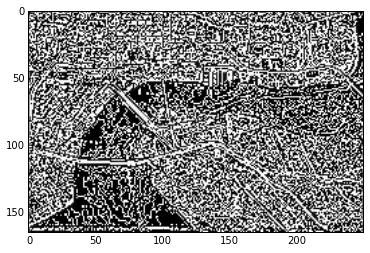

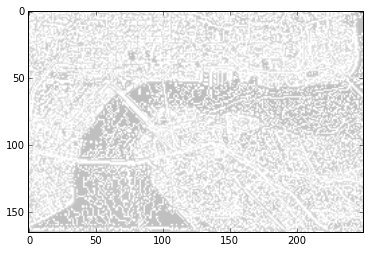

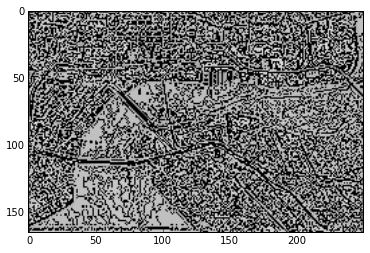

In [51]:
# Import the function to perform laplacian filtering
from scipy.ndimage.filters import laplace

img_lap = laplace(img)
plt.figure()
plt.imshow(img_lap, cmap = cm.Greys_r, vmin=0,vmax=255)
plt.show()

# Enhancing using the laplacian
# Only if the central pixel is positive - Right in our case
c = 1.
img_enh_lap = img + c * img_lap
plt.figure()
plt.imshow(img_enh_lap, cmap = cm.Greys_r, vmin=0,vmax=255)
plt.show()
# Only if the central pixel is negative - Wrong in our case
c = -1.
img_enh_lap = img + c * img_lap
plt.figure()
plt.imshow(img_enh_lap, cmap = cm.Greys_r, vmin=0,vmax=255)
plt.show()

Apply highboost filtering:

1. Blur the original image
2. Subtract the blurred image from the original image
3. Add the mask to the original image

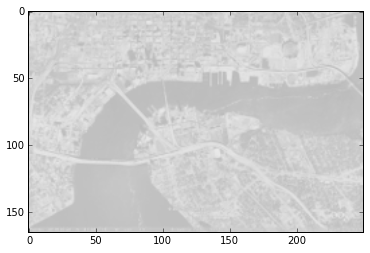

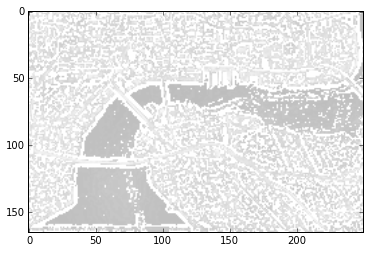

In [52]:
# Blur the image
avg = rank.mean(img, disk(3))

# Subtract the blurred image
mask = img - avg

# Add the mask to the original image
k = 1.5
img_boost = img + k * mask

plt.figure()
plt.imshow(img, cmap = cm.Greys_r, vmin=0,vmax=255)
plt.show()

plt.figure()
plt.imshow(img_boost, cmap = cm.Greys_r, vmin=0,vmax=255)
plt.show()

### Edge detection

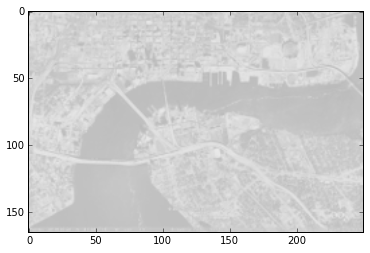

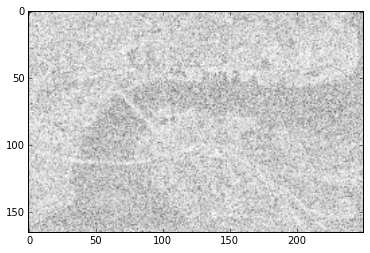

In [48]:
# Add some Gaussian noise 
img_noise = random_noise(img, mode='localvar')

plt.figure()
plt.imshow(img, cmap = cm.Greys_r, vmin=0,vmax=255)
plt.figure()
plt.imshow(img_noise, cmap = cm.Greys_r, vmin=0,vmax=1.)
plt.show()

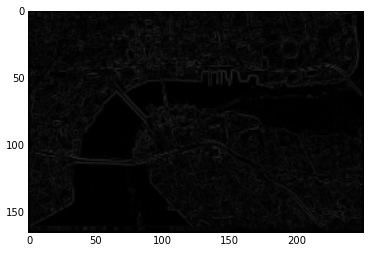

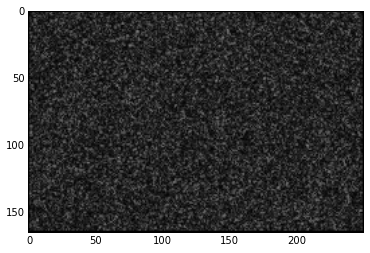

In [43]:
# Edge detection using Robert

img_rob_1 = filters.roberts(img)
img_rob_2 = filters.roberts(img_noise)

plt.figure()
plt.imshow(img_rob_1, cmap = cm.Greys_r, vmin=0,vmax=1.)
plt.figure()
plt.imshow(img_rob_2, cmap = cm.Greys_r, vmin=0,vmax=1.)
plt.show()

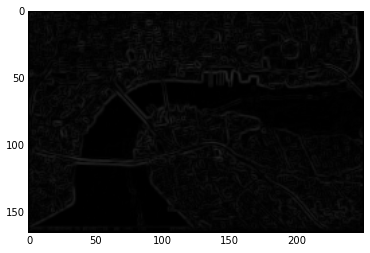

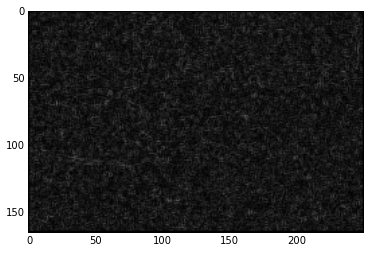

In [46]:
# Edge detection using Prewitt

img_pre_1 = filters.prewitt(img)
img_pre_2 = filters.prewitt(img_noise)

plt.figure()
plt.imshow(img_pre_1, cmap = cm.Greys_r, vmin=0,vmax=1.)
plt.figure()
plt.imshow(img_pre_2, cmap = cm.Greys_r, vmin=0,vmax=1.)
plt.show()

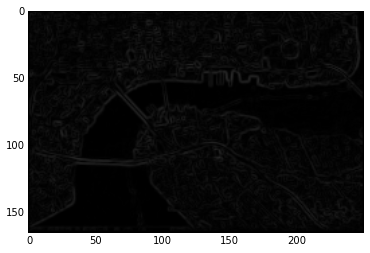

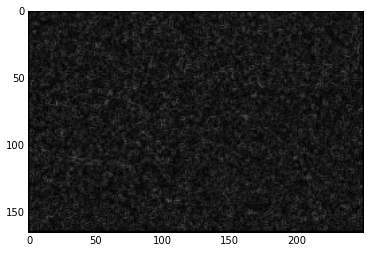

In [47]:
# Edge detection using Sobel

img_sob_1 = filters.sobel(img)
img_sob_2 = filters.sobel(img_noise)

plt.figure()
plt.imshow(img_sob_1, cmap = cm.Greys_r, vmin=0,vmax=1.)
plt.figure()
plt.imshow(img_sob_2, cmap = cm.Greys_r, vmin=0,vmax=1.)
plt.show()